In [1]:
import matplotlib.pyplot as plt
import traintools
from trainconstants import *

%matplotlib inline

df = traintools.read_schedule("datasets/nsdata1.txt")
df.head(10)

,train_number,start,end,departure_time,arrival_time,first_class,second_class
0,2123,2,3,420,460,4,58
1,2123,3,4,463,518,14,328
2,2127,1,2,408,475,47,340
3,2127,2,3,481,521,35,272
4,2127,3,4,523,578,19,181
5,2131,1,2,475,538,100,616
6,2131,2,3,542,581,52,396
7,2131,3,4,583,638,27,270
8,2135,1,2,536,598,61,407
9,2135,2,3,603,643,41,364


In [2]:
minimum_number_of_type_3_trains = traintools.minimum_number_of_trains_at_time_t(df, TYPE_3_TRAIN)
minimum_number_of_type_4_trains = traintools.minimum_number_of_trains_at_time_t(df, TYPE_4_TRAIN)
minimum_number_of_type_3_compartments = traintools.minimum_number_of_trains_at_time_t(df, COMPARTMENT_BASED_ON_3)
minimum_number_of_type_4_compartments = traintools.minimum_number_of_trains_at_time_t(df, COMPARTMENT_BASED_ON_4)

type 3 trains: number of trains    22.0
dtype: float64
type 4 trains: number of trains    17.0
dtype: float64
type 3 compartments: number of trains    62.0
dtype: float64
type 4 compartments: number of trains    62.0
dtype: float64


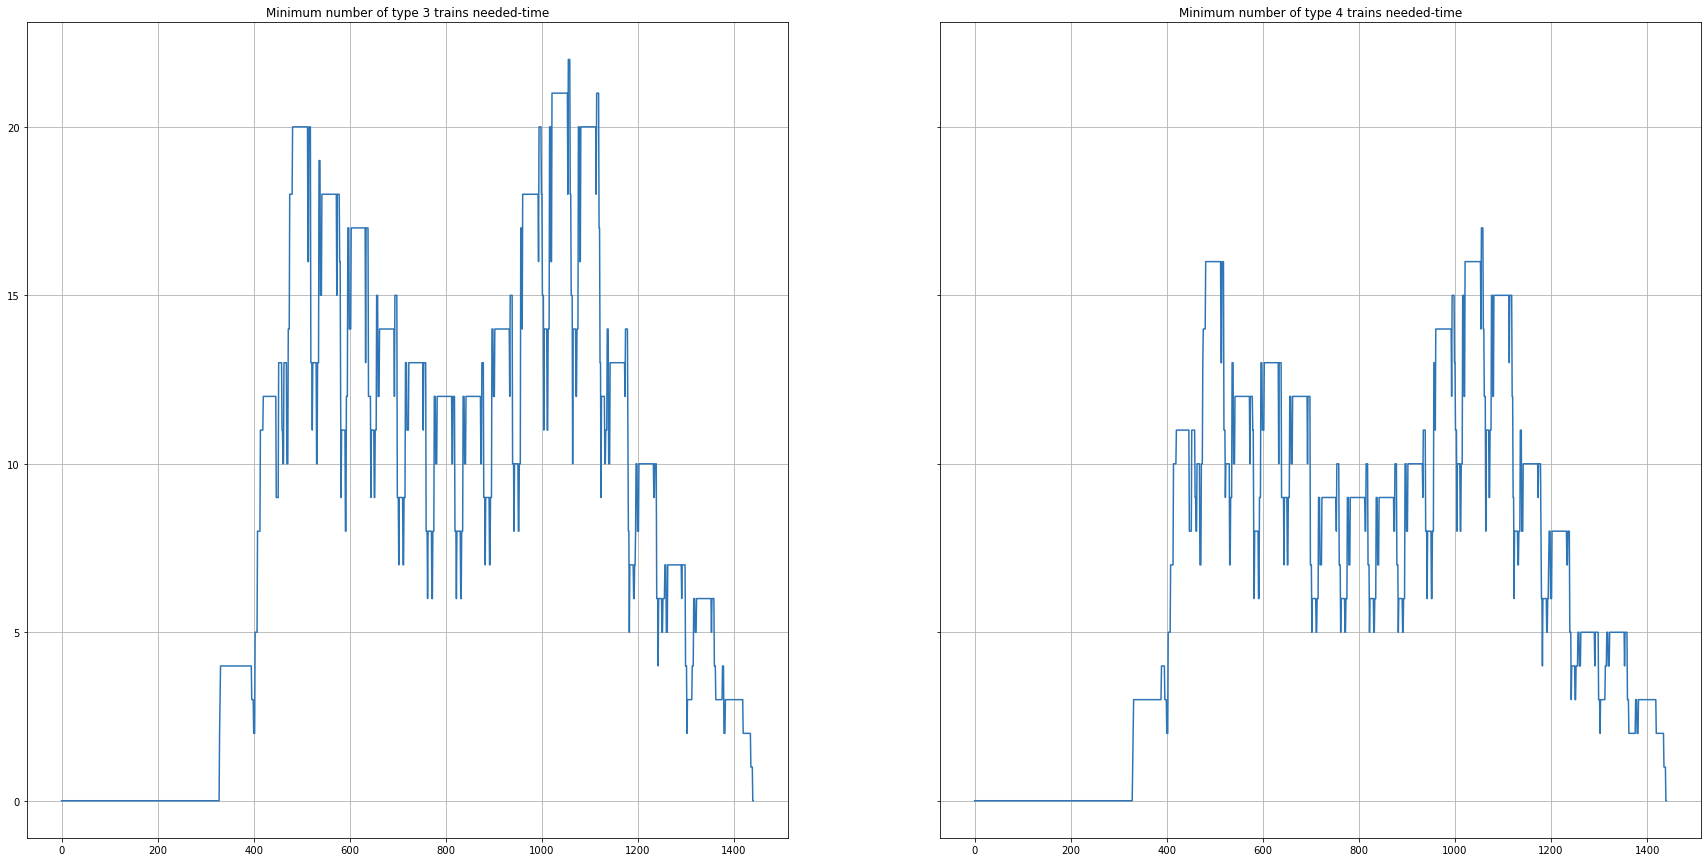

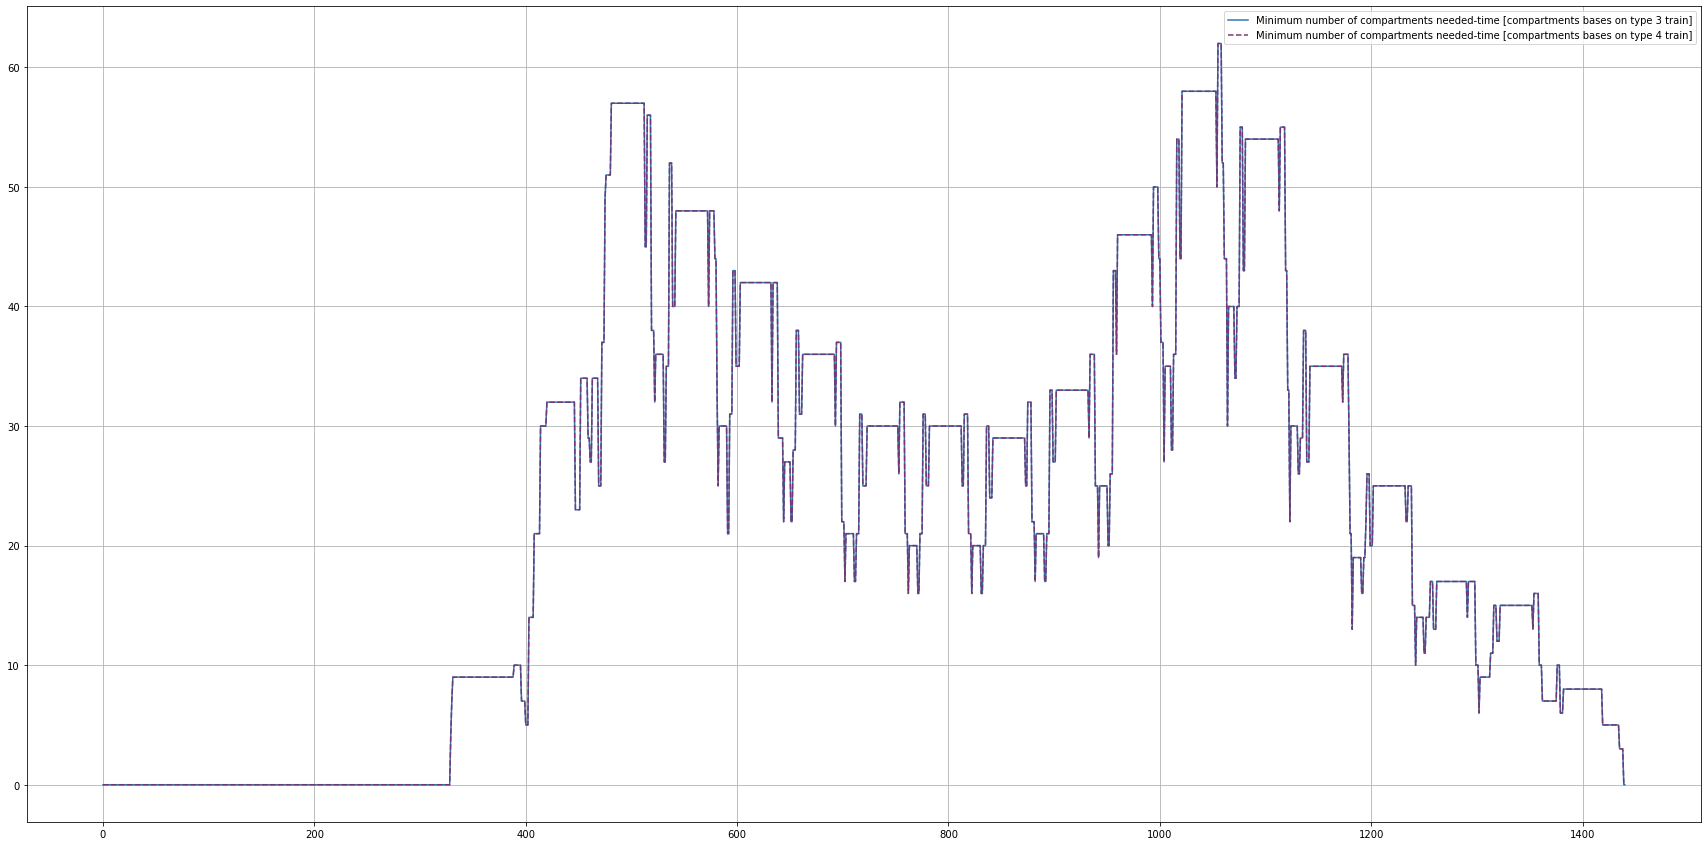

In [3]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(30, 15))
fig2, ax2 = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(30, 15))

minimum_number_of_type_3_trains.plot(ax=ax1[0, 0])
minimum_number_of_type_4_trains.plot(ax=ax1[0, 1])
minimum_number_of_type_3_compartments.plot(ax=ax2[0, 0])
minimum_number_of_type_4_compartments.plot(ax=ax2[0, 0])

ax1[0, 0].set_title('Minimum number of type 3 trains needed-time')
ax1[0, 1].set_title('Minimum number of type 4 trains needed-time')
ax1[0, 0].legend().remove()
ax1[0, 1].legend().remove()
ax2[0, 0].legend([
    'Minimum number of compartments needed-time [compartments bases on type 3 train]', 
    'Minimum number of compartments needed-time [compartments bases on type 4 train]'
    ])
ax1[0, 0].grid(True)
ax1[0, 1].grid(True)
ax2[0, 0].grid(True)

print(f'type 3 trains: {minimum_number_of_type_3_trains.max()}')
print(f'type 4 trains: {minimum_number_of_type_4_trains.max()}')
print(f'type 3 compartments: {minimum_number_of_type_3_compartments.max()}')
print(f'type 4 compartments: {minimum_number_of_type_4_compartments.max()}')

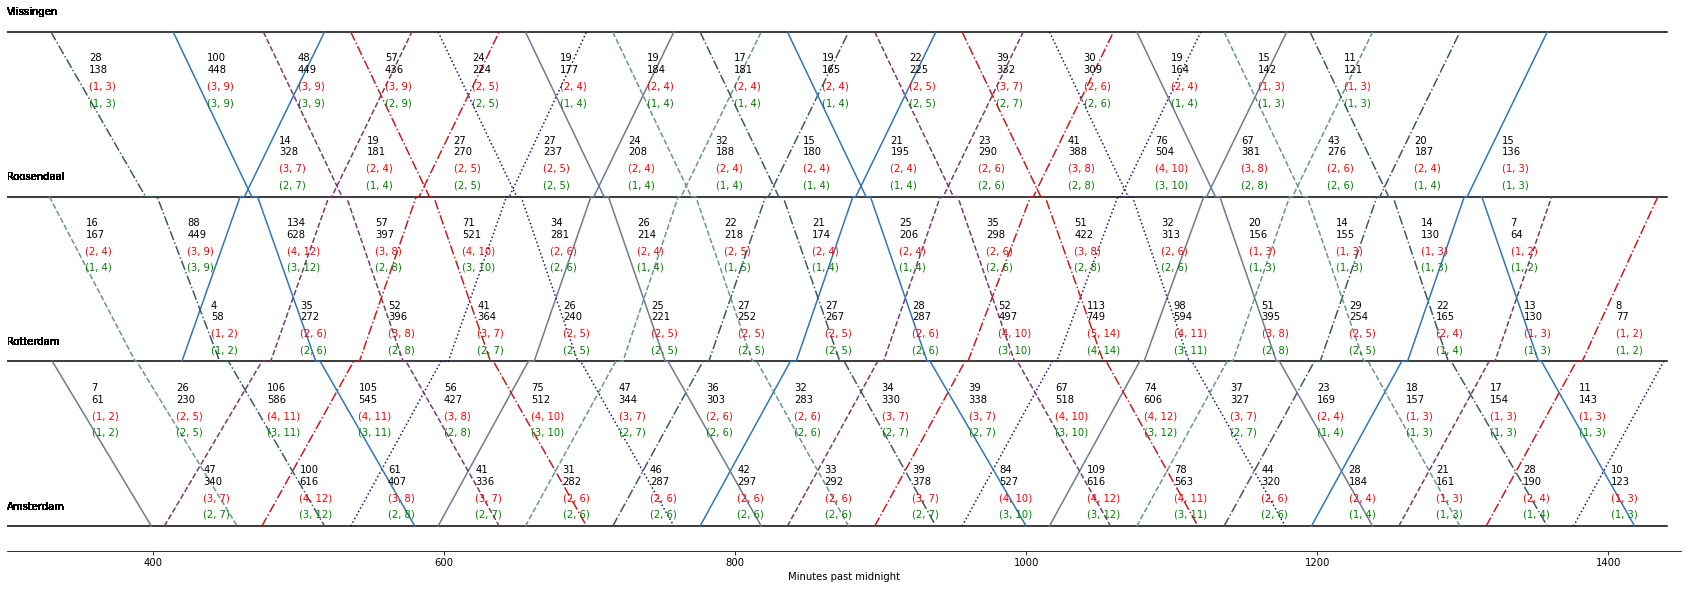

In [4]:
df = traintools.read_schedule("datasets/nsdata1.txt")

%matplotlib inline

trains = traintools.create_trains_dict(df)

# import itertools
# trains_subset = dict(itertools.islice(trains.items(), 10)) # subset of the first 10 trains

viz = traintools.VisualizeSchedule(trains)
viz.visualize()